# Detection

In [124]:
# Todo
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim


### Load data and preprocessing

In [125]:
# Sett seed
SEED = 265
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bildestørrelse
H_in, W_in = 48, 60
# Grid-størrelse
H_out, W_out = 2, 3  

# Last inn bilder fra detection_X.pt (ekte bilder)
imgs_train = torch.load("data/data/detection_train.pt")
imgs_val = torch.load("data/data/detection_val.pt")
imgs_test = torch.load("data/data/detection_test.pt")

# Hent kun bildene fra tuples
train_images = torch.stack([img for img, _ in imgs_train])
val_images = torch.stack([img for img, _ in imgs_val])
test_images = torch.stack([img for img, _ in imgs_test])


# endre tilbake når ferdig testa 
y_true_train = torch.load("data/data/list_y_true_train.pt") 
y_true_val = torch.load("data/data/list_y_true_val.pt")
y_true_test = torch.load("data/data/list_y_true_test.pt")

def convert_to_grid(y_true_list, H_out=2, W_out=3, img_h=48, img_w=60):
    N = len(y_true_list) 
    # Output grid (N, H_out, W_out, 6)
    y_true_grid = torch.zeros((N, H_out, W_out, 6)) 

    for img_idx, objects in enumerate(y_true_list):
        for obj in objects:
            pc, x, y, w, h, c = obj

            grid_h = int(y * H_out)
            grid_w = int(x * W_out)

            x_local = (x - (grid_w / W_out)) * W_out
            y_local = (y - (grid_h / H_out)) * H_out
            w_local = w * W_out
            h_local = h * H_out

            y_true_grid[img_idx, grid_h, grid_w] = torch.tensor([1, x_local, y_local, w_local, h_local, c])

    return y_true_grid


# Konverter labels til grid
labels_train = convert_to_grid(y_true_train, H_out, W_out)
labels_val = convert_to_grid(y_true_val, H_out, W_out)
labels_test = convert_to_grid(y_true_test, H_out, W_out)

# DataLoaders
train_dataset = TensorDataset(train_images, labels_train)
val_dataset = TensorDataset(val_images, labels_val)
test_dataset = TensorDataset(test_images, labels_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test utskrift
images, labels = next(iter(train_loader))
print(f" Images shape: {images.shape}, Labels shape: {labels.shape}")



 Images shape: torch.Size([32, 1, 48, 60]), Labels shape: torch.Size([32, 2, 3, 6])


### Normalize Images

In [126]:
mean = train_images.mean()
std = train_images.std()
transform = transforms.Normalize(mean, std)



In [127]:
class DetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(DetectNet, self).__init__()
        self.num_classes = num_classes
        self.out_channels = num_classes + 5  # (pc, x, y, w, h, c1, c2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 3)

        self.conv_out = nn.Conv2d(64, self.out_channels, kernel_size=3, padding=0)  # gir (batch_size, 7, 2, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool1(x)          
        x = F.relu(self.conv2(x))  
        x = self.pool2(x)          
        x = F.relu(self.conv3(x))  
        x = self.pool3(x)          
        x = self.conv_out(x)       
        return x
"""class DetectNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (48,60) -> (24,30)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (24,30) -> (12,15)

        # Ny kernel og stride for å få (12,15) -> (2,3)
        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))  # (12,15) -> (2,3)

        self.conv_out = nn.Conv2d(16, 7, 1)  # (16, 2, 3) -> (7, 2, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x



class DetectNetLarger(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (48, 60) -> (24, 30)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (24, 30) -> (12, 15)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(6, (6, 5))  # (12, 15) -> (2, 3)

        self.conv_out = nn.Conv2d(64, 7, 1)  # (64, 2, 3) -> (7, 2, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.conv_out(x)
        return x
"""
# får feilmelding med de andre to så prøver uten larger og small

'class DetectNetSmall(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)\n        self.pool1 = nn.MaxPool2d(2, 2)  # (48,60) -> (24,30)\n\n        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)\n        self.pool2 = nn.MaxPool2d(2, 2)  # (24,30) -> (12,15)\n\n        # Ny kernel og stride for å få (12,15) -> (2,3)\n        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))  # (12,15) -> (2,3)\n\n        self.conv_out = nn.Conv2d(16, 7, 1)  # (16, 2, 3) -> (7, 2, 3)\n\n    def forward(self, x):\n        x = self.pool1(F.relu(self.conv1(x)))\n        x = self.pool2(F.relu(self.conv2(x)))\n        x = self.pool3(x)\n        x = self.conv_out(x)\n        return x\n\n\n\nclass DetectNetLarger(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)\n        self.pool1 = nn.MaxPool2d(2, 2)  # (48, 60) -> (24, 30)\n\n        self.conv2 = nn.Conv2d(16, 32, 3, pa

In [128]:
def detection_loss(y_pred, y_true):
    """
    Loss-funksjon for Object Detection med grid.
    """
    # (batch_size, C+5, H_out, W_out) → (batch_size, H_out, W_out, C+5)
    y_pred = y_pred.permute(0, 2, 3, 1)

    # pc-loss
    loss_pc = nn.BCEWithLogitsLoss()(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    # bbox-loss (kun hvis det er et objekt i cellen)
    loss_bbox = torch.where(
        y_true[:, :, :, 0] == 1,
        nn.MSELoss(reduction='none')(y_pred[:, :, :, 1:5], y_true[:, :, :, 1:5]).mean(dim=-1),
        torch.zeros_like(y_true[:, :, :, 0])
    ).mean()

    # class-loss (flatten for CrossEntropy)
    mask = y_true[:, :, :, 0] == 1  # (N, H_out, W_out)

    pred_classes = y_pred[:, :, :, 5:][mask]  # (num_obj, C)
    true_classes = y_true[:, :, :, -1][mask].long()  # (num_obj,)

    if pred_classes.shape[0] > 0:  # Pass på at det finnes noen objekter!
        loss_class = nn.CrossEntropyLoss()(pred_classes, true_classes)
    else:
        loss_class = torch.tensor(0.0, device=y_pred.device)

    return loss_pc + loss_bbox + loss_class


### Training

In [130]:
def train_detection_model(model, train_loader, val_loader, optimizer, num_epochs=50, early_stop_patience=7):
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            preds = model(images)
            loss = detection_loss(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validering
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                preds = model(images)
                val_loss += detection_loss(preds, labels).item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")  # Lagre modellspesifikke filer
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

model = DetectNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train_detection_model(model, train_loader, val_loader, optimizer)

#hvis du skal bruke large anf small dect net 
"""# Sett opp modeller og hyperparametere
model_classes = [DetectNetSmall,DetectNet, DetectNetLarger] # endre rekkefølge tilbake etterpå test
hyperparams_list = [
    {"lr": 0.001, "weight_decay": 0.0001}
]
trained_models = []
for model_class in model_classes:
    for hyperparams in hyperparams_list:
        print(f"\n Trener {model_class.__name__} med params {hyperparams}")

        model = model_class().to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=hyperparams["lr"], weight_decay=hyperparams["weight_decay"])

        train_detection_model(model, train_loader, val_loader, optimizer)
    
        # Lagre modellen og konfigurasjonen for senere evaluering
        trained_models.append({
            "model": model,
            "model_name": model_class.__name__,
            "params": hyperparams
        })"""

Epoch 1/50 | Train Loss: 0.4772 | Val Loss: 0.2652
Epoch 2/50 | Train Loss: 0.2229 | Val Loss: 0.1778
Epoch 3/50 | Train Loss: 0.1707 | Val Loss: 0.1523
Epoch 4/50 | Train Loss: 0.1464 | Val Loss: 0.1404
Epoch 5/50 | Train Loss: 0.1322 | Val Loss: 0.1234
Epoch 6/50 | Train Loss: 0.1201 | Val Loss: 0.1184
Epoch 7/50 | Train Loss: 0.1119 | Val Loss: 0.1068
Epoch 8/50 | Train Loss: 0.1040 | Val Loss: 0.1101
Epoch 9/50 | Train Loss: 0.1014 | Val Loss: 0.0990
Epoch 10/50 | Train Loss: 0.0967 | Val Loss: 0.0967
Epoch 11/50 | Train Loss: 0.0912 | Val Loss: 0.1101
Epoch 12/50 | Train Loss: 0.0880 | Val Loss: 0.0936
Epoch 13/50 | Train Loss: 0.0872 | Val Loss: 0.0982
Epoch 14/50 | Train Loss: 0.0834 | Val Loss: 0.0913
Epoch 15/50 | Train Loss: 0.0822 | Val Loss: 0.1235
Epoch 16/50 | Train Loss: 0.0790 | Val Loss: 0.0900
Epoch 17/50 | Train Loss: 0.0781 | Val Loss: 0.0878
Epoch 18/50 | Train Loss: 0.0739 | Val Loss: 0.0943
Epoch 19/50 | Train Loss: 0.0741 | Val Loss: 0.0893
Epoch 20/50 | Train L

'# Sett opp modeller og hyperparametere\nmodel_classes = [DetectNetSmall,DetectNet, DetectNetLarger] # endre rekkefølge tilbake etterpå test\nhyperparams_list = [\n    {"lr": 0.001, "weight_decay": 0.0001}\n]\ntrained_models = []\nfor model_class in model_classes:\n    for hyperparams in hyperparams_list:\n        print(f"\n Trener {model_class.__name__} med params {hyperparams}")\n\n        model = model_class().to(DEVICE)\n        optimizer = optim.Adam(model.parameters(), lr=hyperparams["lr"], weight_decay=hyperparams["weight_decay"])\n\n        train_detection_model(model, train_loader, val_loader, optimizer)\n    \n        # Lagre modellen og konfigurasjonen for senere evaluering\n        trained_models.append({\n            "model": model,\n            "model_name": model_class.__name__,\n            "params": hyperparams\n        })'

### Prediction

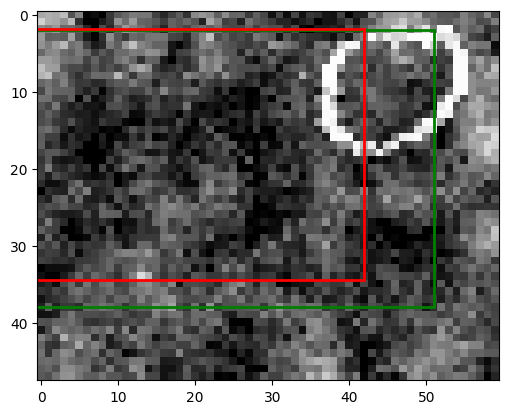

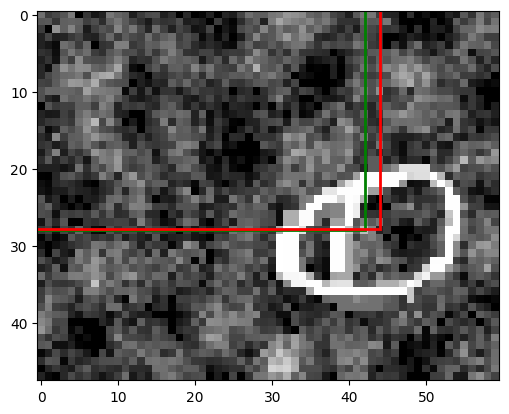

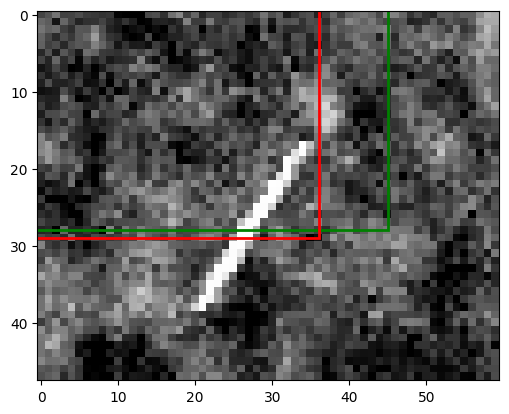

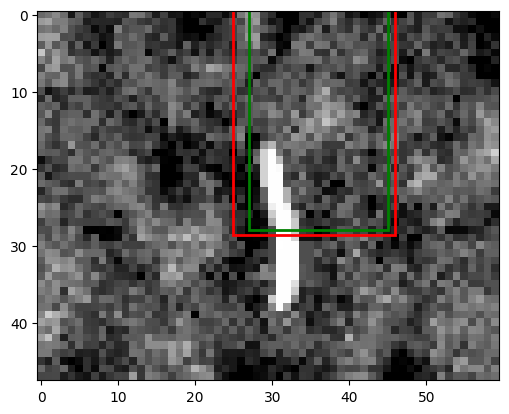

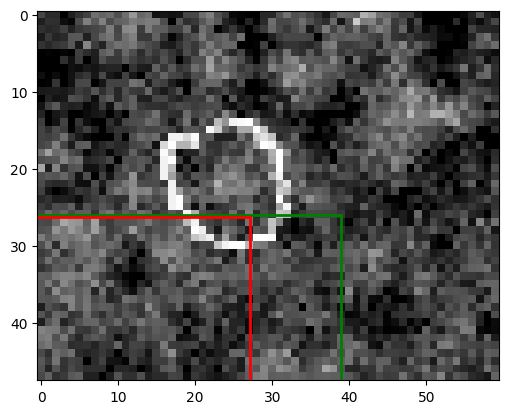

In [131]:
def plot_predictions(model, loader, num_images=5):
    """
    Visualiser sanne og predikerte bounding boxes.
    """
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth")) # henter den best modellen om jeg fåt til å kegge til de andre 

    model.eval()

    images, labels = next(iter(loader))  # Hent en batch
    preds = model(images.to(DEVICE)).cpu().detach()
    preds = preds.permute(0, 2, 3, 1)  # Nå (batch_size, H_out, W_out, C+5)

    for i in range(num_images):
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")

        for h in range(H_out):   # Iterer over rader
            for w in range(W_out):  # Iterer over kolonner
                if labels[i, h, w, 0].item() == 0:
                    continue  # Hopper over grid-celler uten objekt

                true_bb = labels[i, h, w, 1:5].cpu().numpy()
                pred_bb = preds[i, h, w, 1:5].cpu().numpy()

                # Tegn sann bounding box (grønn)
                plt.gca().add_patch(plt.Rectangle(
                    (true_bb[0] * 60 - true_bb[2] * 30, true_bb[1] * 48 - true_bb[3] * 24),
                    true_bb[2] * 60, true_bb[3] * 48,
                    edgecolor='green', linewidth=2, fill=False))

                # Tegn predikert bounding box (rød)
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bb[0] * 60 - pred_bb[2] * 30, pred_bb[1] * 48 - pred_bb[3] * 24),
                    pred_bb[2] * 60, pred_bb[3] * 48,
                    edgecolor='red', linewidth=2, fill=False))

        plt.show()

# Kjør prediksjonene
plot_predictions(model, test_loader)



### Model selection and evaluation

In [132]:

def evaluate_detection_model(model, test_loader):
    """
    Evaluerer modellen på testsettet.
    """
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    model.eval()

    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            test_loss += detection_loss(preds, labels).item()

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

# Kjør evaluering
evaluate_detection_model(model, test_loader)

def compute_IoU_detection(model, loader):
    model.eval()
    total_iou = 0
    count = 0

    print("\n🔍 Beregner Intersection over Union (IoU)...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)  # Korriger dimensjon

            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            iou = IoU(preds[i, h, w, 1:5].cpu().numpy(), labels[i, h, w, 1:5].cpu().numpy())
                            total_iou += iou
                            count += 1

            if batch_idx % 10 == 0:
                print(f"   Batch {batch_idx+1}/{len(loader)} - Akkumulert IoU: {total_iou/count if count > 0 else 0:.4f}")

    avg_iou = total_iou / count if count > 0 else 0
    print(f"\n [RESULTAT] Gjennomsnittlig IoU for modellen: {avg_iou:.4f}")
    return avg_iou




def compute_accuracy_detection(model, loader):
    model.eval()
    correct = 0
    total = 0

    print("\n Beregner klassifikasjonsnøyaktighet...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)  # Korriger dimensjon

            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            pred_label = preds[i, h, w, 5:].argmax().item()
                            true_label = labels[i, h, w, -1].item()
                            if pred_label == true_label:
                                correct += 1
                            total += 1

            if batch_idx % 10 == 0:
                print(f"   Batch {batch_idx+1}/{len(loader)} - Akkumulert nøyaktighet: {correct / total if total > 0 else 0:.4f}")

    accuracy = correct / total if total > 0 else 0
    print(f"\n [RESULTAT] Klassifikasjonsnøyaktighet for modellen: {accuracy:.4f}")
    return accuracy



Test Loss: 0.0895


In [133]:
def plot_predictions_with_labels(model, loader, num_images=5):
    """
    Visualiser sanne og predikerte bounding boxes + skriv ut labels.
    """
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))

    model.eval()

    # Finn en batch med objekter
    for images, labels in loader:
        if (labels[:, :, :, 0].sum() > 0):  # sjekk om det finnes minst ett objekt i batchen
            break

    preds = model(images.to(DEVICE)).cpu().detach()
    preds = preds.permute(0, 2, 3, 1)  # (batch_size, H_out, W_out, C+5)

    count = 0
    for i in range(len(images)):
        if count >= num_images:
            break

        if labels[i, :, :, 0].sum() == 0:
            continue  # hopp over bilde uten objekter

        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")

        for h in range(H_out):
            for w in range(W_out):
                if labels[i, h, w, 0].item() == 0:
                    continue

                true_bb = labels[i, h, w, 1:5].cpu().numpy()
                pred_bb = preds[i, h, w, 1:5].cpu().numpy()

                true_class = int(labels[i, h, w, -1].item())
                pred_class = int(preds[i, h, w, 5:].argmax().item())

                # Tegn sann bounding box (grønn)
                plt.gca().add_patch(plt.Rectangle(
                    (true_bb[0] * W_in - true_bb[2] * W_in / 2, true_bb[1] * H_in - true_bb[3] * H_in / 2),
                    true_bb[2] * W_in, true_bb[3] * H_in,
                    edgecolor='green', linewidth=2, fill=False))
                
                plt.text(true_bb[0] * W_in, true_bb[1] * H_in - 5, f"True: {true_class}", color="green")

                # Tegn predikert bounding box (rød)
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bb[0] * W_in - pred_bb[2] * W_in / 2, pred_bb[1] * H_in - pred_bb[3] * H_in / 2),
                    pred_bb[2] * W_in, pred_bb[3] * H_in,
                    edgecolor='red', linewidth=2, fill=False))
                
                plt.text(pred_bb[0] * W_in, pred_bb[1] * H_in + 5, f"Pred: {pred_class}", color="red")

        plt.title(f"Bilde {count+1}")
        plt.show()
        count += 1
